In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from tqdm import tqdm

from scipy.stats import gaussian_kde

In [2]:
import matplotlib

matplotlib.rcParams.update(
    {
        # Adjust to your LaTex-Engine
        "pgf.texsystem": "xelatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
    }
)

matplotlib.rcParams['figure.figsize'] = (8, 6)

100%|██████████| 10000/10000 [00:00<00:00, 356458.45it/s]


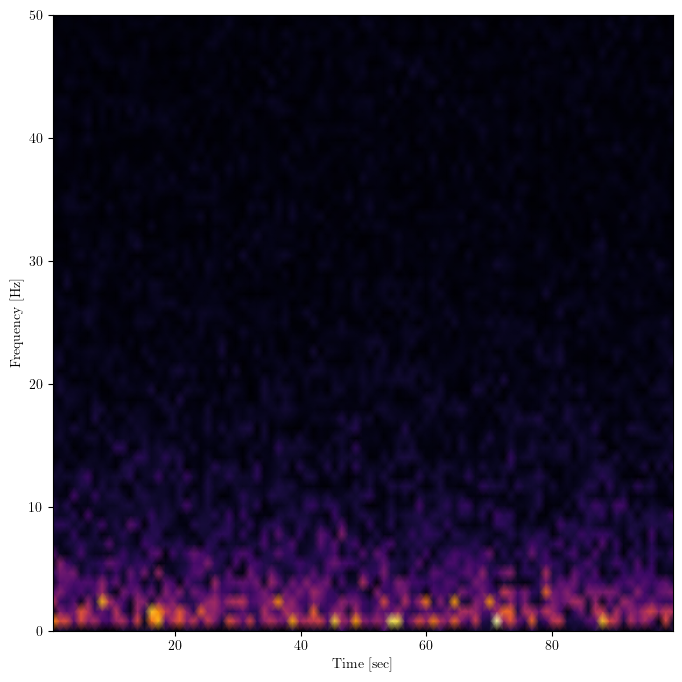

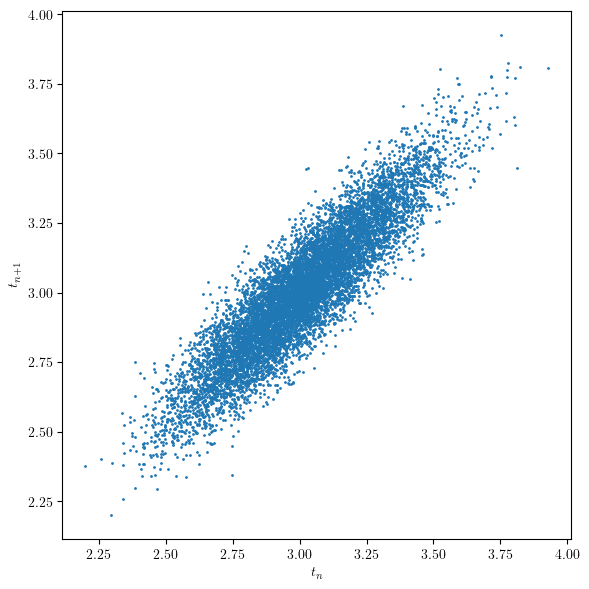

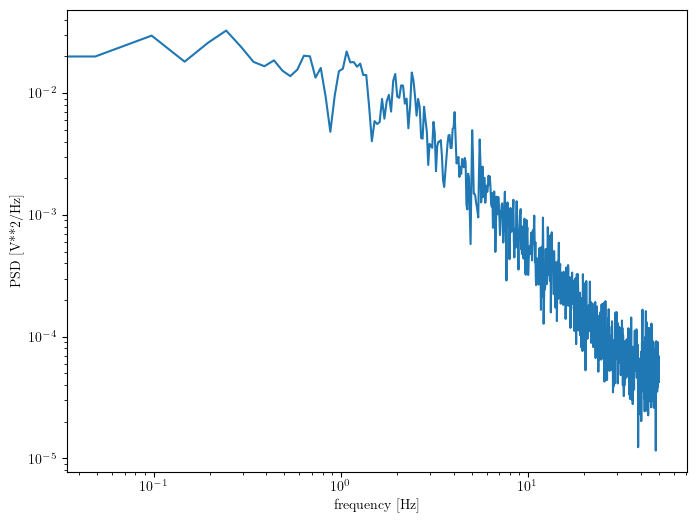

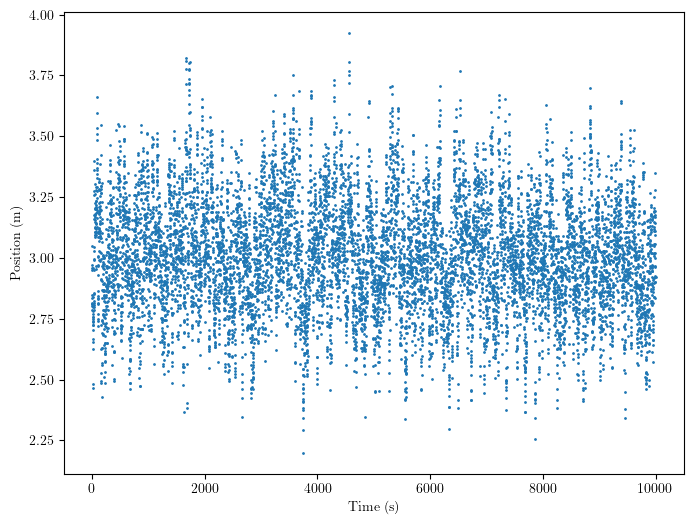

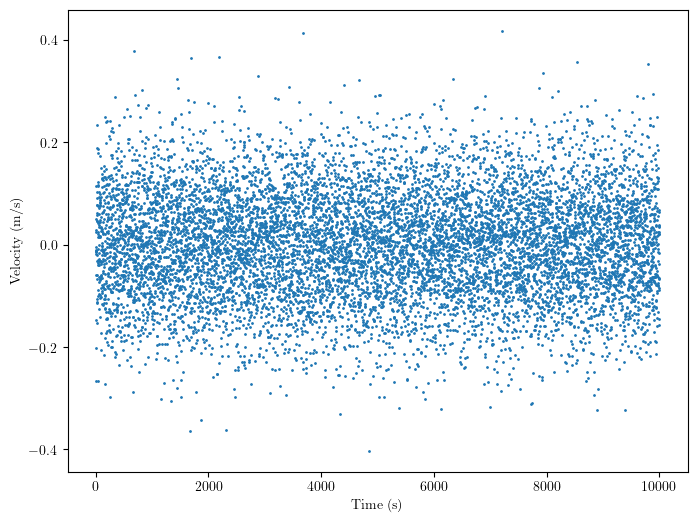

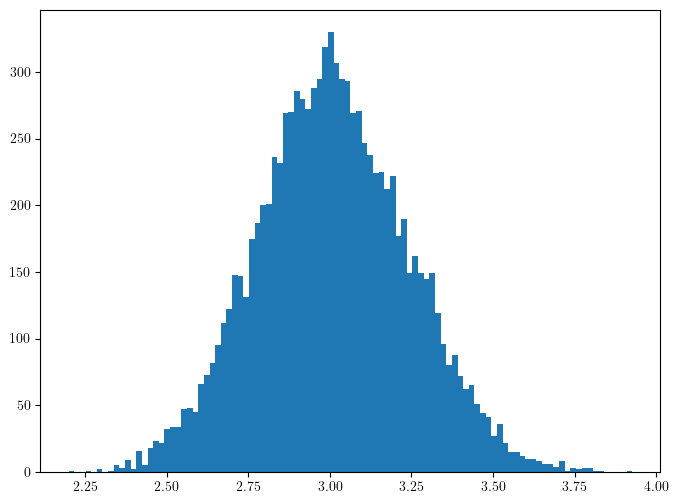

In [45]:
# Parameters
N = 10000
k = 0.1  # Restoring force constant
d = 1  # Damping constant
b = 0.1  # Noise intensity
dt = 1

# Initialise
x_exp = 3
x = x_exp
v = 0
a = 0

# Initialise arrays
x_data = np.zeros(N)
v_data = np.zeros(N)
t_data = np.zeros(N)

# Loop
for i in tqdm(range(N)):
    # Restoring and damping force
    a = (-k*(x - x_exp))
    a -= d*v*dt

    # Apply velocity change
    v += a*dt + b*np.random.normal()*dt

    # Apply position change
    x += v*dt

    # Add to arrays
    x_data[i] = x
    v_data[i] = v
    t_data[i] = i*dt

x_data = np.asarray(x_data)

f, t, Sxx = signal.spectrogram(x_data, fs = 10e1, nperseg = 128, scaling = "spectrum")
plt.figure(figsize = (8,8))
plt.pcolormesh(t, f, Sxx**0.5, shading='gouraud', cmap = "inferno")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.figure(figsize = (6,6))
plt.scatter(x_data[0:-1], x_data[1::], s = 1)
plt.xlabel("$t_n$")
plt.ylabel("$t_{n+1}$")
plt.tight_layout()
plt.show()

from scipy import signal
fs = 10e1
f, Pxx_den = signal.welch(x_data, fs, nperseg=2048)
plt.semilogy(f, Pxx_den)
plt.xscale("log")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Plot
plt.scatter(t_data, x_data, s = 1)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.show()

plt.scatter(t_data, v_data, s = 1)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.show()

plt.hist(x_data, bins = 100)
plt.show()

In [8]:
print(scipy.__version__)

1.10.1


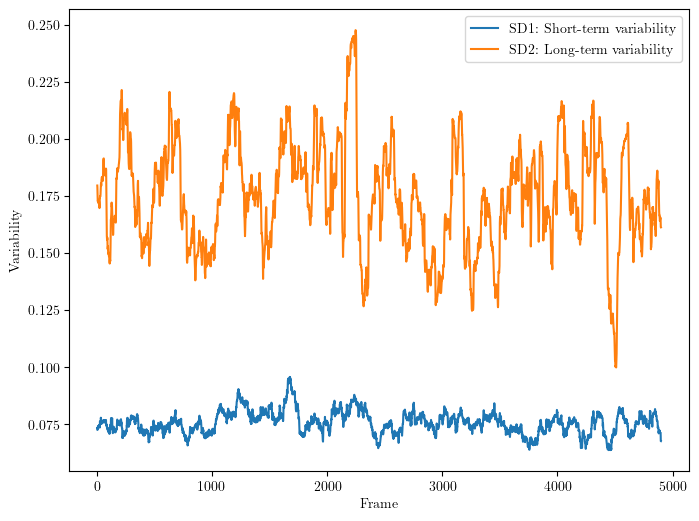

In [36]:
window = 100
sd1s = []
sd2s = []
for i in range(0, x_data.shape[0] - window, 1):
    RR_1 = x_data[i:i + window]
    RR_2 = x_data[i + 1:i + window + 1]

    x_1 = (RR_1 - RR_2) / 2**(0.5)
    x_2 = (RR_1 + RR_2) / 2**(0.5)

    sd1 = np.sqrt(np.var(x_1))
    sd2 = np.sqrt(np.var(x_2))

    sd1s.append(sd1)
    sd2s.append(sd2)

plt.plot(sd1s, label = "SD1: Short-term variability")
plt.plot(sd2s, label = "SD2: Long-term variability")
plt.ylabel("Variability")
plt.xlabel("Frame")
plt.legend()
plt.show()

In [4]:
x = x_data[0:-1]
y = x_data[1::]

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([x, y])

kernel = gaussian_kde(values)

Z = np.reshape(kernel(positions).T, X.shape)

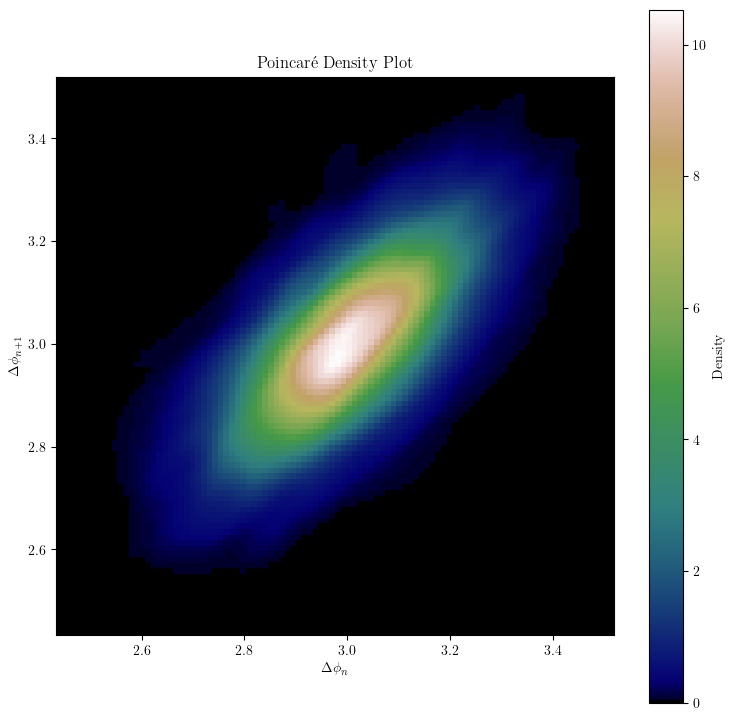

In [5]:
plt.figure(figsize = (9,9))
plt.title("Poincaré Density Plot")
plt.imshow(Z, origin = "lower", cmap = "gist_earth", extent = [xmin, xmax, ymin, ymax], interpolation = "none")
plt.xlabel(r"$\Delta \phi_{n}$")
plt.ylabel(r"$\Delta \phi_{n+1}$")
plt.colorbar(label = "Density")
plt.show()

In [6]:
# Gets the noise spectrum by looking at the standard deviation of the change in delta phases over some time period.
def get_noise_spectrum(delta_phases, averaging_window):
    time_windows = range(1, (delta_phases.shape[0] - averaging_window) // 2, 1)
    avg_delta_phases_std = []
    for time_window in tqdm(time_windows):
        avg_delta_phases = []
        for i in np.arange(0, delta_phases.shape[0] - time_window - averaging_window, time_window):
            average_delta_phase_init = np.mean(delta_phases[i:i + averaging_window])
            average_delta_phase_final = np.mean(delta_phases[i + time_window:i + time_window + averaging_window])

            est_avg_delta_phases = average_delta_phase_init - average_delta_phase_final
            avg_delta_phases.append(est_avg_delta_phases)

        avg_delta_phases_std.append(np.std(avg_delta_phases))

    return time_windows, avg_delta_phases_std

100%|██████████| 2494/2494 [00:00<00:00, 4299.06it/s]


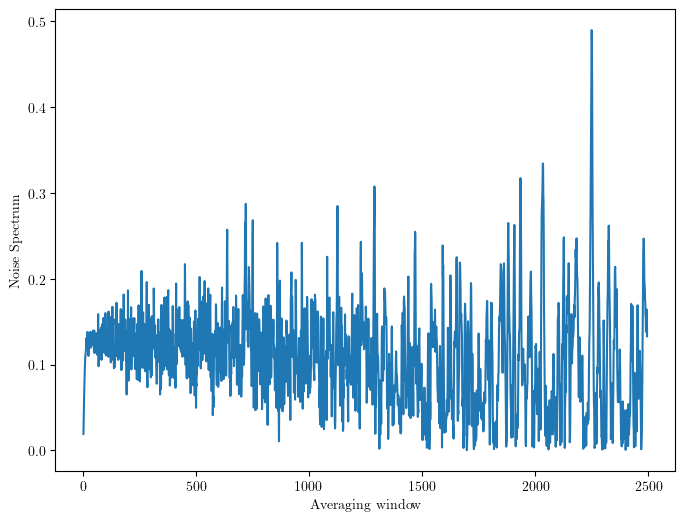

In [37]:
plt.plot(*get_noise_spectrum(x_data, 10))
plt.xlabel("Averaging window")
plt.ylabel("Noise Spectrum")
plt.show()